<a href="https://colab.research.google.com/github/delhian/cv_course/blob/main/Home%20Tasks/flower_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from typing import Tuple
import numpy as np
from torch.utils.data import Dataset, Subset
import torch
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn

from torchvision import models
from tqdm.notebook import tqdm


from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import ExponentialLR
from PIL import Image

In [3]:
torch.cuda.is_available()

True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/flowerdata-module5.zip'
!unzip -qqo {path} -d ./

# split train/validation with stratification

In [6]:
path = '/content/train/train/'

files = []
for (dirpath, _, filenames) in os.walk(path):
  for f in filenames:
    if f.endswith('.jpg'):
      label = int(dirpath.split('/')[-1]) - 1
      files.append([dirpath+'/'+f, label, f,])
files = pd.DataFrame(files, columns = ['path','label','filename',])

files[['label']].value_counts()

label
50       206
76       205
45       157
88       153
72       147
        ... 
34        33
25        33
32        31
33        28
0         27
Length: 102, dtype: int64

In [7]:
train_files, val_files = train_test_split(files, test_size=0.25, stratify= files.label, random_state=13)

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


train_transforms = transforms.Compose([\
                                              transforms.RandomRotation(45),
                                              transforms.RandomResizedCrop(224),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.RandomVerticalFlip(),
                                              transforms.ToTensor()
                                       ])
val_transforms = transforms.Compose([
                                              transforms.Resize(256),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor()
                                     ])

In [9]:
class CustomDataset(Dataset):
    def __init__(self, files, transform, normalize = None):
        files = files.reset_index(drop = True)
        self.paths = files['path'].to_dict()
        self.labels = files['label'].to_dict()
        self.filenames = files['filename'].to_dict()
        self.transform = transform
        self.normalize = normalize
    def __len__(self):
        return len(self.paths)

    def pil_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, idx):
        path = self.paths[idx]
        # print(path)
        label = self.labels[idx]
        label = torch.LongTensor([label]).squeeze() 
        file_name = self.filenames[idx]
        image = self.pil_loader(path)
        image = self.transform(image)
        if self.normalize:
            image = self.normalize(image)
        return image, file_name, label

In [10]:
train_dataset = CustomDataset(files = train_files, transform=train_transforms, )
val_dataset = CustomDataset(files = val_files, transform=val_transforms)

In [11]:
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())

train_dataloader:


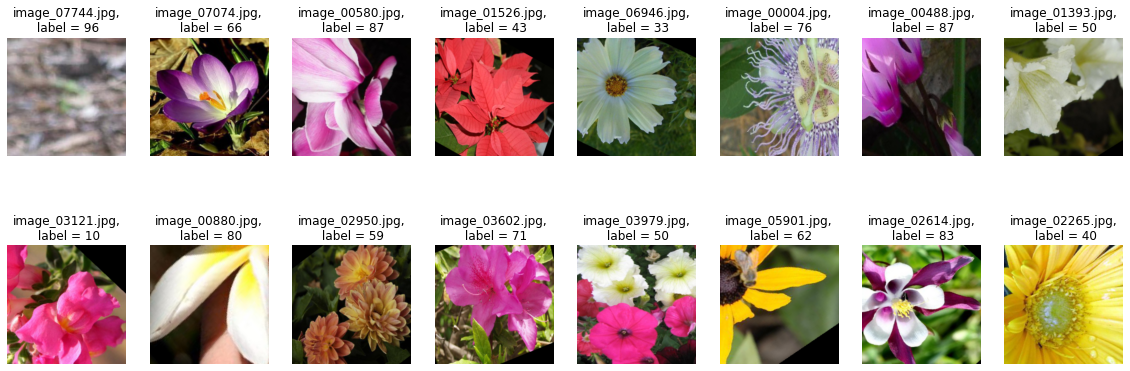

val_dataloader:


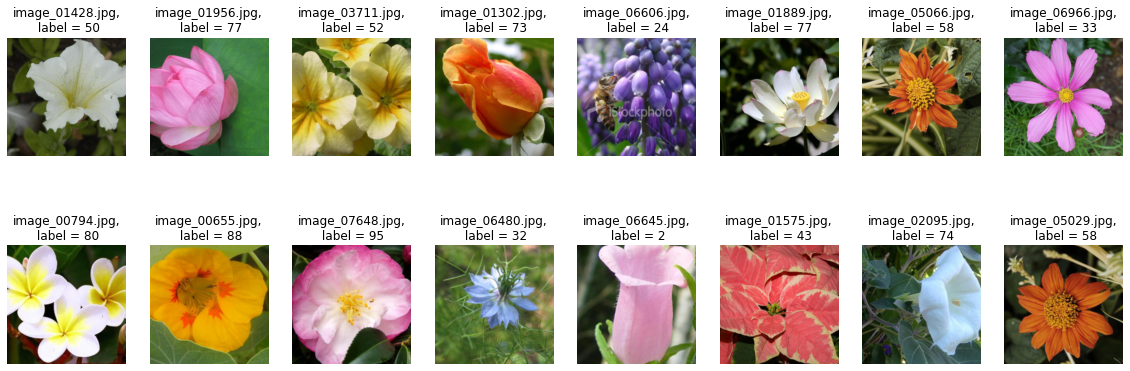

In [12]:
def plot_examples(image, file_name, label):
  figure = plt.figure(figsize=(20, 7))
  cols, rows = 8, 2
  for i in range(0, cols * rows):

    figure.add_subplot(rows, cols, i+1)

    plt.title(f'{file_name[i]},\n label = {label[i].item()}')
    plt.axis("off")
    plt.imshow(image[i].numpy().transpose([1,2,0]))
  plt.show()

print('train_dataloader:')
image, file_name, label = next(iter(train_dataloader))
plot_examples(image, file_name, label)
print('val_dataloader:')
image, file_name, label = next(iter(val_dataloader))
plot_examples(image, file_name, label)

In [13]:
batch_size = 32
train_dataset = CustomDataset(files = train_files, transform=train_transforms, normalize = normalize)
val_dataset = CustomDataset(files = val_files, transform=val_transforms, normalize = normalize)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
net = models.densenet201(pretrained=True)
# net = models.resnet34(pretrained=True)
# net.fc = torch.nn.Linear(in_features=512, out_features=102, bias=True)


for parameter in net.parameters():
    parameter.requres_grad = True

# for module in [net.conv1, net.bn1, net.layer1, net.layer2]:
#     for parameter in module.parameters():
#         parameter.requres_grad = False

net.classifier =  torch.nn.Linear(in_features=1920, out_features=102, bias=True)

net= net.to(device)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

In [16]:
# # net = models.efficientnet_b1(pretrained=True)
# net = models.resnet34(pretrained=True)
# net.fc = torch.nn.Linear(in_features=512, out_features=102, bias=True)

# for parameter in net.parameters():
#     parameter.requres_grad = True

# for module in [net.conv1, net.bn1, net.layer1, net.layer2]:
#     for parameter in module.parameters():
#         parameter.requres_grad = False

# net= net.to(device)

In [17]:
checkpoint_path = '/content/drive/MyDrive/checkpoint.pth'

def save_checkpoint(model, optimizer, checkpoint_path, epoch):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, checkpoint_path)

def load_checkpoint(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch

In [18]:
def train_model(net,
                optimizer,
                criterion,
                train_dataloader,
                val_dataloader,
                num_epochs):
  
    # check checkpoint
    try:
      net, optimizer, start_epoch = load_checkpoint(net, checkpoint_path)
    except:
      start_epoch = 0
  
    loss_train, loss_valid = [], []
    f1_train, f1_valid = [], []

    scheduler = ExponentialLR(optimizer, gamma=0.95)

    for epoch in range(start_epoch + 1, num_epochs):
        print(f'epoch: {epoch} of {num_epochs}')
        print(f'LR: {scheduler.get_last_lr()[0]}')
        torch.set_grad_enabled(True)
        net.train()
        losses, f1 = [], []
        print('TRAIN:', end =' ')
        for i, (image, _, label) in enumerate(tqdm(train_dataloader)):
            # print(i, end =', ')
            image = image.to(device)
            label = label.to(device)
            output = net(image)
            loss = criterion(output, label)
            try:
              losses.append(loss.item())
            except:
              return losses, loss

            f1.append(f1_score(label.cpu().numpy(), output.argmax(1).cpu().numpy(), average='macro'))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        mean_losses, mean_f1 = np.mean(losses),  np.mean(f1)
        print(f'mean_losses: {mean_losses}, mean_f1: {mean_f1}')
        loss_train.append(mean_losses)
        f1_train.append(mean_f1)
        torch.set_grad_enabled(False)
        net.eval()
        losses, f1 = [], []
        print('VALIDATION:', end =' ')
        for i, (image, _, label) in enumerate(tqdm(val_dataloader)):
            # print(i, end =', ')
            image = image.to(device)
            label = label.to(device)
            output = net(image)
            loss = criterion(output, label)
            losses.append(loss.item())
            f1.append(f1_score(label.cpu().numpy(), net(image).argmax(1).cpu().numpy(), average='macro'))
        mean_losses, mean_f1 = np.mean(losses),  np.mean(f1)
        print(f'mean_losses: {mean_losses}, mean_f1: {mean_f1}')

        loss_valid.append(mean_losses)
        f1_valid.append(mean_f1)
        scheduler.step()
        save_checkpoint(net, optimizer, checkpoint_path, epoch)

    return loss_train, f1_train, loss_valid, f1_valid

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [ ]:
loss_train, f1_train, loss_valid, f1_valid = train_model(net = net,
                                                             optimizer = optimizer,
                                                             criterion = criterion,
                                                             train_dataloader = train_dataloader,
                                                             val_dataloader = val_dataloader,
                                                             num_epochs = 150)

epoch: 87 of 150
LR: 0.0001074670919654805
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.16878850081959715, mean_f1: 0.9193738649601996
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.35198511406689736, mean_f1: 0.8855838204044544
epoch: 88 of 150
LR: 0.00010209373736720646
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.1671642843488749, mean_f1: 0.9134291634355871
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.31780522882651824, mean_f1: 0.8926977165687984
epoch: 89 of 150
LR: 9.698905049884614e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.16238697415048425, mean_f1: 0.922704551390924
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.3089023405349368, mean_f1: 0.8982919521848193
epoch: 90 of 150
LR: 9.213959797390383e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.1620536617354139, mean_f1: 0.9187138436092628
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.23509940691740036, mean_f1: 0.8924373386646358
epoch: 91 of 150
LR: 8.753261807520862e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.14987365932312685, mean_f1: 0.9264696443468754
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.22991980916748828, mean_f1: 0.8926035767135894
epoch: 92 of 150
LR: 8.315598717144818e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.1504712067121132, mean_f1: 0.9311735266551336
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.22074739002961835, mean_f1: 0.8900928547069895
epoch: 93 of 150
LR: 7.899818781287577e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.16616867429443768, mean_f1: 0.9190949392976159
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.3411416522083947, mean_f1: 0.8980488140222224
epoch: 94 of 150
LR: 7.504827842223198e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.1461931873905146, mean_f1: 0.9352019078783494
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.22777158909369832, mean_f1: 0.8997143790055584
epoch: 95 of 150
LR: 7.129586450112038e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.1427396910065519, mean_f1: 0.9267854036210583
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.32304810657380867, mean_f1: 0.8934580587309683
epoch: 96 of 150
LR: 6.773107127606435e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.13836457416439404, mean_f1: 0.929044852080892
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.23294422564168388, mean_f1: 0.8960964567828011
epoch: 97 of 150
LR: 6.434451771226113e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.1503700889108775, mean_f1: 0.9271911449390642
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.23872638665712798, mean_f1: 0.9009544418883653
epoch: 98 of 150
LR: 6.112729182664806e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.15679738052830391, mean_f1: 0.922613423266724
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.23649315000511706, mean_f1: 0.9000589471456746
epoch: 99 of 150
LR: 5.807092723531566e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.14664338485567602, mean_f1: 0.925459027016989
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.41954438866545946, mean_f1: 0.8949160017765846
epoch: 100 of 150
LR: 5.516738087354988e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.16280187894408774, mean_f1: 0.9205798070481305
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.24970385935515738, mean_f1: 0.8933346545965446
epoch: 101 of 150
LR: 5.240901182987238e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.14798104064841452, mean_f1: 0.9282660188915232
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.28799194110055953, mean_f1: 0.8906431610335344
epoch: 102 of 150
LR: 4.978856123837876e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.15311423101607566, mean_f1: 0.9227232964077017
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.34272118700811494, mean_f1: 0.8822277106240897
epoch: 103 of 150
LR: 4.729913317645982e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.15354320592573517, mean_f1: 0.9269078602008269
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.3508809329225467, mean_f1: 0.8960382918345852
epoch: 104 of 150
LR: 4.4934176517636825e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.16119729306294836, mean_f1: 0.9258091623821043
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.37405943700398964, mean_f1: 0.8912841285384852
epoch: 105 of 150
LR: 4.268746769175498e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.16855526791111408, mean_f1: 0.9211211981958498
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.28683400080682564, mean_f1: 0.8952388898816507
epoch: 106 of 150
LR: 4.055309430716723e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.15388812696222554, mean_f1: 0.9261984229396442
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.22635911901488726, mean_f1: 0.9009511044255133
epoch: 107 of 150
LR: 3.8525439591808865e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.1470255228666613, mean_f1: 0.9272706422791783
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.3405787094961677, mean_f1: 0.8875589108840871
epoch: 108 of 150
LR: 3.659916761221842e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.1538174598501971, mean_f1: 0.9259387887068933
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.29462518110925046, mean_f1: 0.9059907163262012
epoch: 109 of 150
LR: 3.47692092316075e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.14429777589711276, mean_f1: 0.9289804792024843
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.2931272217359107, mean_f1: 0.8955245127635391
epoch: 110 of 150
LR: 3.303074877002713e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.14177652343793154, mean_f1: 0.9317432942048439
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.2522975254015854, mean_f1: 0.8924599919781068
epoch: 111 of 150
LR: 3.137921133152577e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.14046810072387098, mean_f1: 0.9285806547466123
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.40138745851492363, mean_f1: 0.8881277610790508
epoch: 112 of 150
LR: 2.981025076494948e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.1425481314722497, mean_f1: 0.9288116657528936
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.2274226720462768, mean_f1: 0.8944592204549345
epoch: 113 of 150
LR: 2.8319738226702005e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.13336605050105166, mean_f1: 0.938148100997461
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.2750489770416887, mean_f1: 0.9021594392280287
epoch: 114 of 150
LR: 2.6903751315366905e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.13710507798286808, mean_f1: 0.9358845494181903
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.28540170125220005, mean_f1: 0.8923612118264207
epoch: 115 of 150
LR: 2.555856374959856e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.1384622262512612, mean_f1: 0.9326943716254715
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.23036319080095452, mean_f1: 0.9020251461371441
epoch: 116 of 150
LR: 2.428063556211863e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.14192603544827986, mean_f1: 0.9328068057199003
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.22578785817425412, mean_f1: 0.9022996652098308
epoch: 117 of 150
LR: 2.30666037840127e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.14756091204229985, mean_f1: 0.931791336251822
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.2078386686547534, mean_f1: 0.9042765634677389
epoch: 118 of 150
LR: 2.1913273594812064e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.1461977256286599, mean_f1: 0.9321957094403586
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.2763262152080782, mean_f1: 0.9019427132989211
epoch: 119 of 150
LR: 2.0817609915071458e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.12700219428190937, mean_f1: 0.9360475776468847
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.38167112257752495, mean_f1: 0.8983275836268992
epoch: 120 of 150
LR: 1.9776729419317883e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.14841745198740589, mean_f1: 0.9302511890994419
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.34298497427740726, mean_f1: 0.8961582774172091
epoch: 121 of 150
LR: 1.8787892948351987e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.1376952921620921, mean_f1: 0.9352311371810899
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.268758901511319, mean_f1: 0.8927860159345286
epoch: 122 of 150
LR: 1.784849830093439e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.15195457317545866, mean_f1: 0.9263713407339426
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.4068505723642794, mean_f1: 0.9038034870580185
epoch: 123 of 150
LR: 1.695607338588767e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.150013473816216, mean_f1: 0.9323071522411348
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.2461693768765634, mean_f1: 0.8969334772918491
epoch: 124 of 150
LR: 1.6108269716593287e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.15340916070385607, mean_f1: 0.9253481968792603
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.26073543643220687, mean_f1: 0.9016443703037247
epoch: 125 of 150
LR: 1.530285623076362e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.1351776708237972, mean_f1: 0.9329063587946006
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

mean_losses: 0.272506343823177, mean_f1: 0.8995116027416231
epoch: 126 of 150
LR: 1.453771341922544e-05
TRAIN: 

  0%|          | 0/154 [00:00<?, ?it/s]

mean_losses: 0.13561100990197003, mean_f1: 0.9381130573429036
VALIDATION: 

  0%|          | 0/52 [00:00<?, ?it/s]

In [1]:
8plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
plt.xlabel("epochs")
plt.title("loss")

plt.subplot(122)
plt.plot(range(1, len(loss_train) + 1), f1_train, color="b")
plt.plot(range(1, len(loss_train) + 1), f1_valid, color="r")
plt.xlabel("epochs")
plt.title("mean_f1")

plt.show()

SyntaxError: ignored

In [ ]:
from PIL import Image

class TestDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.files = []
        for (dirpath, _, filenames) in os.walk(self.path):
            for f in filenames:
                if f.endswith('.jpg'):
                    p = {}
                    p['img_path'] = dirpath + '/' + f
                    self.files.append(p)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def pil_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, idx):
        img_path = self.files[idx]['img_path']
        file_name = img_path.split('/')[-1]
        image = self.pil_loader(img_path)
        if self.transform:
            image = self.transform(image)
        return image, file_name

In [ ]:
test_transforms = transforms.Compose([
                                              transforms.Resize((299, 299)),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406],
                                                                 [0.229, 0.224, 0.225])
                                     ])

test_transforms_without_Normalize  = transforms.Compose([
                                              transforms.Resize((299, 299)),
                                              transforms.ToTensor(),
                                              # transforms.Normalize([0.485, 0.456, 0.406],
                                              #                    [0.229, 0.224, 0.225])
                                     ])


test_dataset = TestDataset('/content/train/train/1', transform=test_transforms)
test_dataset_without_Normalize = TestDataset('/content/train/train/1', transform=test_transforms_without_Normalize)
# testloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
test_dataset[0]

(tensor([[[-1.7412, -1.7069, -1.7240,  ..., -1.0390, -1.0390, -1.1075],
          [-1.7412, -1.7412, -1.7754,  ..., -1.0390, -1.0219, -1.1247],
          [-1.7583, -1.7583, -1.7583,  ..., -1.0904, -1.0733, -1.1589],
          ...,
          [-1.2103, -1.1247, -1.0048,  ..., -1.8097, -1.8097, -1.8097],
          [-1.1418, -1.0390, -0.8678,  ..., -1.7754, -1.7583, -1.7412],
          [-0.3541, -0.2856, -0.1828,  ..., -0.7137, -0.6965, -0.6794]],
 
         [[-1.6681, -1.6331, -1.6506,  ..., -0.4601, -0.4426, -0.5126],
          [-1.6681, -1.6681, -1.7031,  ..., -0.4251, -0.4076, -0.4951],
          [-1.6856, -1.6856, -1.6856,  ..., -0.4076, -0.3901, -0.4601],
          ...,
          [-0.6877, -0.5651, -0.3725,  ..., -1.6506, -1.6681, -1.6506],
          [-0.7577, -0.6176, -0.3901,  ..., -1.6856, -1.6681, -1.6506],
          [ 0.0476,  0.1527,  0.3102,  ..., -0.6001, -0.5826, -0.5651]],
 
         [[-1.4733, -1.4384, -1.4559,  ..., -1.1770, -1.2119, -1.3164],
          [-1.4733, -1.4733,

In [ ]:
next(iter(test_dataset))

(tensor([[[-1.7412, -1.7069, -1.7240,  ..., -1.0390, -1.0390, -1.1075],
          [-1.7412, -1.7412, -1.7754,  ..., -1.0390, -1.0219, -1.1247],
          [-1.7583, -1.7583, -1.7583,  ..., -1.0904, -1.0733, -1.1589],
          ...,
          [-1.2103, -1.1247, -1.0048,  ..., -1.8097, -1.8097, -1.8097],
          [-1.1418, -1.0390, -0.8678,  ..., -1.7754, -1.7583, -1.7412],
          [-0.3541, -0.2856, -0.1828,  ..., -0.7137, -0.6965, -0.6794]],
 
         [[-1.6681, -1.6331, -1.6506,  ..., -0.4601, -0.4426, -0.5126],
          [-1.6681, -1.6681, -1.7031,  ..., -0.4251, -0.4076, -0.4951],
          [-1.6856, -1.6856, -1.6856,  ..., -0.4076, -0.3901, -0.4601],
          ...,
          [-0.6877, -0.5651, -0.3725,  ..., -1.6506, -1.6681, -1.6506],
          [-0.7577, -0.6176, -0.3901,  ..., -1.6856, -1.6681, -1.6506],
          [ 0.0476,  0.1527,  0.3102,  ..., -0.6001, -0.5826, -0.5651]],
 
         [[-1.4733, -1.4384, -1.4559,  ..., -1.1770, -1.2119, -1.3164],
          [-1.4733, -1.4733,

In [ ]:
filelist['filename'][7]

'image_06742.jpg'

In [ ]:
next(iter(train_dataset))

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.2275, 0.2275, 0.2235],
          [0.0000, 0.0000, 0.0000,  ..., 0.2196, 0.2314, 0.2314],
          [0.0000, 0.0000, 0.0000,  ..., 0.2275, 0.2314, 0.2314],
          ...,
          [0.1294, 0.1294, 0.1333,  ..., 0.1569, 0.1529, 0.1529],
          [0.1255, 0.1255, 0.1294,  ..., 0.1490, 0.1490, 0.1490],
          [0.1255, 0.1216, 0.1294,  ..., 0.1412, 0.1412, 0.1412]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.2471, 0.2471, 0.2431],
          [0.0000, 0.0000, 0.0000,  ..., 0.2431, 0.2431, 0.2431],
          [0.0000, 0.0000, 0.0000,  ..., 0.2471, 0.2431, 0.2431],
          ...,
          [0.1843, 0.1843, 0.1882,  ..., 0.1765, 0.1725, 0.1725],
          [0.1804, 0.1804, 0.1843,  ..., 0.1686, 0.1686, 0.1686],
          [0.1804, 0.1765, 0.1843,  ..., 0.1608, 0.1569, 0.1569]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.2627, 0.2627, 0.2588],
          [0.0000, 0.0000, 0.0000,  ..., 0.2667, 0.2627, 0.2627],
          [0.0000, 0.0000, 0.0000,  ...,

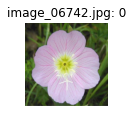

In [ ]:
figure = plt.figure(figsize=(25, 7))
cols, rows = 8, 4

for i in range(cols * rows):
    img, _ = test_dataset[i]
    img_w, filename = test_dataset_without_Normalize[i]
    img = img.to(device)
    output = net.forward(img[None, :, :, :])
    tt= output
    output = output.argmax(1).cpu().numpy()
    figure.add_subplot(rows, cols, i+1)

    img_w = img_w.swapaxes(0,1)
    img_w = img_w.swapaxes(1,2)
    plt.title(f'{filename}: {output[0]}')
    plt.axis("off")
    plt.imshow(img_w)

    break

In [ ]:
testloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [ ]:
images, filename = next(iter(testloader))
images = images.to(device)
output = net(images)
output = output.argmax(1).cpu().numpy()
Id_Category_map = {x:y for (x ,y) in zip(filename, output)}

In [ ]:
submission = pd.read_csv('sample_submission.csv')

submission['Category'] = submission['Id'].map(Id_Category_map)

In [ ]:
submission.to_csv('submission.csv', index=False)
pd.read_csv('submission.csv')

,Id,Category
0,image_00028.jpg,83
1,image_00059.jpg,77
2,image_00061.jpg,77
3,image_00063.jpg,77
4,image_00071.jpg,77
...,...,...
813,image_08105.jpg,11
814,image_08113.jpg,95
815,image_08145.jpg,55
816,image_08155.jpg,85
